In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.optimizers import RMSprop # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical # type: ignore

In [7]:

data_path = '../data/district_classification_dataset_v4.csv'
df = pd.read_csv(data_path)
df.head()

,students_passed,num_teachers,total_students,Total_budget,dropout_rate,avg_class_size,school_distance,district_label
0,449,31,690,18475,12,58,4,Kicukiro
1,513,64,2529,5130,8,41,2,Kicukiro
2,993,17,547,6902,7,55,6,Kicukiro
3,597,29,2866,7367,21,48,4,Kicukiro
4,202,39,2157,14033,10,30,8,Kicukiro


In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602 entries, 0 to 2601
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   students_passed  2602 non-null   int64 
 1   num_teachers     2602 non-null   int64 
 2   total_students   2602 non-null   int64 
 3   Total_budget     2602 non-null   int64 
 4   dropout_rate     2602 non-null   int64 
 5   avg_class_size   2602 non-null   int64 
 6   school_distance  2602 non-null   int64 
 7   district_label   2602 non-null   object
dtypes: int64(7), object(1)
memory usage: 162.8+ KB


,students_passed,num_teachers,total_students,Total_budget,dropout_rate,avg_class_size,school_distance
count,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000,2602.000000
mean,509.180246,54.405842,1747.534204,12442.577633,14.643736,39.410069,4.981553
std,287.695185,26.002761,713.973205,4367.054784,8.480675,11.413036,2.590248
min,0.000000,10.000000,500.000000,5001.000000,0.000000,20.000000,1.000000
25%,261.250000,32.000000,1139.250000,8660.750000,7.000000,29.250000,3.000000
50%,513.000000,54.500000,1770.500000,12399.500000,15.000000,40.000000,5.000000
75%,757.750000,77.000000,2357.500000,16286.250000,22.000000,49.000000,7.000000
max,999.000000,99.000000,2998.000000,19997.000000,29.000000,59.000000,9.000000


In [9]:
encoder = OneHotEncoder(sparse_output=False)
district_encoded = encoder.fit_transform(df[['district_label']])

X_numeric = df[['students_passed', 'num_teachers', 'total_students', 'Total_budget', 'dropout_rate', 'avg_class_size','school_distance' ]].values
X = np.hstack((X_numeric, district_encoded))

district_mapping = {'Nyarugenge': 0, 'Kicukiro': 1, 'Gasabo': 2}
df['target'] = df['district_label'].map(district_mapping)
y = df['target'].values

X.shape, y.shape


((2602, 10), (2602,))

In [10]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")


Training set size: (1821, 10), Validation set size: (390, 10), Test set size: (391, 10)


In [11]:

scaler = StandardScaler()
X_train[:, :4] = scaler.fit_transform(X_train[:, :4])
X_val[:, :4] = scaler.transform(X_val[:, :4])
X_test[:, :4] = scaler.transform(X_test[:, :4])


In [14]:
model = Sequential()
input_shape = X_train.shape[1]
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2)),
model.add(Dropout(0.3)),
model.add(layers.Dense(126, activation='relu', kernel_regularizer=l2)),
model.add(Dropout(0.3)),
model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2)),
model.add(Dropout(0.3)),
model.add(layers.Dense(3, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])


Epoch 1/100


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3627 - loss: 5.3440 - val_accuracy: 0.3590 - val_loss: 2.4898
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3621 - loss: 2.6984 - val_accuracy: 0.3564 - val_loss: 2.1986
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3689 - loss: 2.1827 - val_accuracy: 0.3974 - val_loss: 1.9298
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3764 - loss: 1.9239 - val_accuracy: 0.3897 - val_loss: 1.7325
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3822 - loss: 1.6916 - val_accuracy: 0.3897 - val_loss: 1.5749
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3809 - loss: 1.5325 - val_accuracy: 0.3897 - val_loss: 1.4429
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3619 - loss: 1.4281 - val_accuracy: 0.3897 - val_loss: 1.3507
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3856 - loss: 1.3376 - val_accuracy: 0.3897 - val_loss: 1.2

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0621 
Test Loss: 0.06224948912858963, Test Accuracy: 1.0


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Confusion Matrix:
 [[147   0   0]
 [  0  91   0]
 [  0   0 153]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00        91
           2       1.00      1.00      1.00       153

    accuracy                           1.00       391
   macro avg       1.00      1.00      1.00       391
weighted avg       1.00      1.00      1.00       391


Model Performance Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


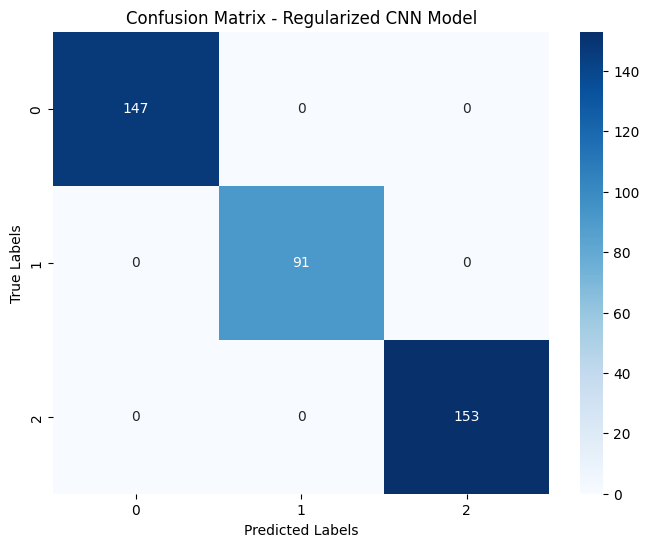

In [18]:


# making a prediction on the test data using the regularized model
r_pred_prob = model.predict(X_test)  # Predict probabilities
r_pred_labels = np.argmax(r_pred_prob, axis=1)  # Get the predicted class labels from the probabilities

# getting the true labels of the test data and comparing them with the predicted labels
# Ensure y_test is the correct ground truth labels for the test set
r_true_labels = y_test  # If y_test is one-hot encoded, we need to get the class index

# Confusion matrix
conf_matrix = confusion_matrix(r_true_labels, r_pred_labels)
print("\nConfusion Matrix:\n", conf_matrix)

# Getting the class names
class_names = y_test.columns if hasattr(y_test, 'columns') else range(len(np.unique(r_true_labels)))  
# If y_test is in one-hot format, it will have 'columns' attribute, otherwise we use range for label indices

# Classification report
print("\nClassification Report:\n", classification_report(r_true_labels, r_pred_labels, target_names=[str(i) for i in class_names]))

# Calculating the performance metrics of the model using the true and predicted labels
accuracy = accuracy_score(r_true_labels, r_pred_labels)
precision = precision_score(r_true_labels, r_pred_labels, average='weighted')  
recall = recall_score(r_true_labels, r_pred_labels, average='weighted')  
f1 = f1_score(r_true_labels, r_pred_labels, average='weighted') 

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in class_names], 
            yticklabels=[str(i) for i in class_names])
plt.title('Confusion Matrix - Regularized CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [21]:
import joblib

model.save('../model/district_classification_model.h5')